In [1]:
from scanner import *

### Assumptions

1. Every edge for every building is divided into subparts if the length is very large. For example, a stadium's edge even though it is straight, will be divided into multiple edges to make sure the edge is detected in the scanner. This is required as the scanner's range is restricted. Doing this has no performance hit as the bottleneck is the number of features in edge, so the splitting has no performance hit on ***this*** algorithm.
2. Buildings are convex. If not, split the building into convex parts and the overlapping edges with no feature points

### Algorithm

- Tag all nodes, edges based on FOV
- Find all the buildings that are there in the given FOV
    - A building is visible if either the edge is tagged in FOV or the vertex is tagged in FOV
- For all buildings get the frontier set of edges based on the ORIGIN
- Valid edges are current all edges that are tagged in FOV as well as in the frontier.
- Remove edges from this set that are overshadowed
- Calculate the effective scope of each building
- For every building scope, remove edges that are overshadowed by this scope

base_angle  135.0
viewpoint  [-84.39708585385976, 33.777629486307696]
viewpoint_begin  [-84.39736355483159, 33.777096027704175]
viewpoint_end  [-84.39655239525625, 33.777907187279524]
axis_xp  [-84.3956716402974, 33.7776294863077]
axis_xn  [-84.39708585385975, 33.77621527274532]
spans
{0: [29, 32], 1: [36, 38], 2: [43, 44], 3: [48, 45], 4: [56, 59], 5: [64, 66]}



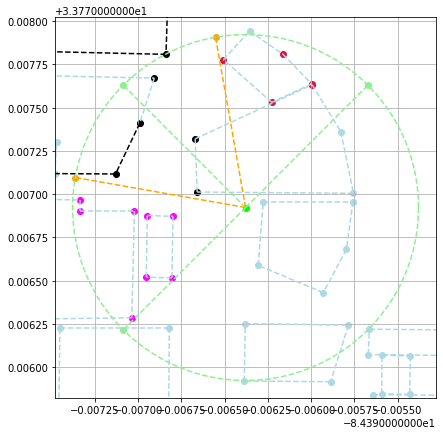

In [5]:
if ORIGINAL_DATA:
    radius = 0.001
#     origin = [33.77435829374495, -84.397344643052] # Tech green
#     origin = [33.7754096889298, -84.39580062968061] # Bus Stop
#     origin = [33.77567129853454, -84.39715893627394] # Hive
#     origin = [33.77637681793485, -84.39690871277799] # Pettit
    origin = [33.77692237952651, -84.39637874707857] # Klaus
#     origin = [33.77570781753953, -84.39607218474292] # Industrial Design
    origin.reverse()

    DIFF = 0.001
else:
    radius = 6.5
    origin = [4, 4]

    DIFF = 0.1

direction = [-1, 1]

edges = tag_edges_by_view(origin, direction, radius)

In [3]:
edges

,tag,p1_tag,p2_tag,virtual,color,start,end
0,culc_main_entrance,culc0,culc1,0,lightblue,0,1
1,culc_back_1,culc1,culc2,0,lightblue,1,2
2,culc_conn,culc2,culc3,1,lightblue,2,3
3,culc_back_entrance,culc3,culc4,0,lightblue,3,4
4,culc_tg,culc4,culc0,0,lightblue,4,0
...,...,...,...,...,...,...,...
78,eastarch13,eastarch13,eastarch10,0,black,78,75
79,eastarch20,eastarch20,eastarch21,0,lightblue,79,80
80,eastarch21,eastarch21,eastarch22,0,lightblue,80,81
81,eastarch22,eastarch22,eastarch23,0,lightblue,81,82
